# Practical Work 3 - Convolutional neural network (CNN)
# Question 2 : CNN For Colorize a grayscale image

## Introduction

Main goal: 
The CNN is trained with grayscale images as input and colored images as output. The training has already been carried out, so you must build the model and load the network parameters.

## Imports

In [3]:
# Classical libraries
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os 
import os.path
from os import path
import tensorflow

# Keras via Tensorflow library
import tensorflow.keras as tk

# Import datasets, layers, models and optimizers.
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Conv2D,Flatten,Reshape,Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import plot_model
gpu=tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(gpu[0], True)

2024-10-28 09:27:37.378484: E external/local_xla/xla/stream_executor/plugin_registry.cc:93] Invalid plugin kind specified: DNN
2024-10-28 09:27:37.423767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 09:27:38.908565: I external/local_xla/xla/stream_executor/rocm/rocm_gpu_executor.cc:773] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:01.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-28 09:27:38.995801: I external/local_xla/xla/stream_executor/rocm/rocm_gpu_executor.cc:773] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:01.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-28 09:27:38.995854: I external/local_xla/xla/stream_executor/rocm/rocm_gpu_exec

## CIFAR10 dataset loading
The Cifar10 data is loaded. The parameters of the database are retrieved (number of examples, of classes, size of the retina).

In [4]:
# Cifar10 dataset loading
# The data, shuffled and split between train and test sets:
(x_train, _), (x_test, _) = cifar10.load_data()
num_classes = 10
print('X_train shape: {}'.format(x_train.shape))
print('train samples: {}'.format(x_train.shape[0]))
print('test samples: {}'.format(x_test.shape[0]))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# input image dimensions
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]
print('Number of rows {}'.format(img_rows))
print('Number of columns {}'.format(img_cols))
print('Number of channels {}'.format(channels))

170498071/170498071 [==============================] - 21s 0us/step
X_train shape: (50000, 32, 32, 3)
train samples: 50000
test samples: 10000
Number of rows 32
Number of columns 32
Number of channels 3


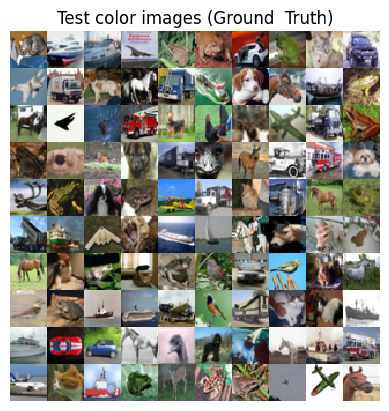

In [5]:
# create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

# display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

(10000, 32, 32, 1)


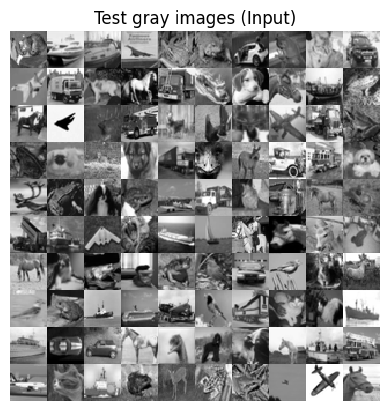

In [6]:
def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

x_train_gray = x_train_gray.reshape(list(x_train_gray.shape) + [1])
x_test_gray = x_test_gray.reshape(list(x_test_gray.shape) + [1])
print(x_test_gray.shape)

# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [14]:
# network parameters
input_shape = (img_rows, img_cols,1)
batch_size  = 32
kernel_size = 3
strides     = 2
padding     = 'same'

# Create a sequential model
model = Sequential()
# Add layers : stack of Conv2D(filters=64,strides=2)-Conv2D(filters=128,strides=2)-Conv2D(filters=256,strides=2)-Flatten-Dense(256)-Dense(4096)-Reshape-Conv2DTranspose(filters=256,strides=2)-Conv2DTranspose(filters=128,strides=2)-Conv2DTranspose(filters=64,strides=2) - Conv2DTranspose(filters=3(number of channels),strides=1)
model.add(Input(shape=(32,32,1)))
model.add(Conv2D(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'))
model.add(Conv2D(128, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'))
model.add(Conv2D(256, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Reshape((4, 4, 256)))
model.add(Conv2DTranspose(256, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'))
model.add(Conv2DTranspose(128, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'))
model.add(Conv2DTranspose(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'))
model.add(Conv2DTranspose(3, kernel_size=kernel_size, strides=1, padding=padding, activation='relu'))
model.summary()

# Save an image file with the structure of the model
plot_model(model, '%s/model.png' % imgs_dir, show_shapes=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        640       
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 conv2d_21 (Conv2D)          (None, 4, 4, 256)         295168    
                                                                 
 flatten_6 (Flatten)         (None, 4096)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               1048832   
                                                                 
 dense_13 (Dense)            (None, 4096)              1052672   
                                                                 
 reshape_6 (Reshape)         (None, 4, 4, 256)        

2024-10-28 09:35:11.390705: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:35:11.392015: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:35:11.400138: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:35:11.401263: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:35:11.408948: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:35:11.410133: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:35:11.420659: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:35:11.422209: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:35:11.430056: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:35:11

## Loading weights from disk
[Link for China](https://tensorflow.google.cn/guide/keras/save_and_serialize?hl=en#apis_for_saving_weights_to_disk_loading_them_back)


In [18]:

# TODO : load the parameters inside the file 'colorized_model.015.h5'
# Online documentation => Keras function : load_weights(.......)
model.load_weights(os.getcwd()+'/weigths/colorized_model.015.h5')


2024-10-28 09:40:28.477939: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:40:28.480568: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:40:28.484643: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:40:28.486441: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:40:28.498124: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:40:28.499993: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:40:28.509817: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:40:28.516408: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:40:28.518128: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:40:28

In [24]:
model.compile(optimizer=Adam(learning_rate=0), loss='mean_absolute_error', metrics=['acc'])
hist=model.fit( x_train_gray,x_train, epochs=3, batch_size=32,verbose=1)

2024-10-28 09:42:34.867601: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:34.869213: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:34.875234: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:34.876124: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:34.883635: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:34.884812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


Epoch 1/3


2024-10-28 09:42:35.136464: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:35.137485: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:35.144237: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:35.145266: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:35.146147: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:35.147120: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:35.157811: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:35.162836: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:35.165916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:42:35

1563/1563 [==============================] - 20s 12ms/step - loss: 0.3690 - acc: 0.5294
Epoch 2/3
  16/1563 [..............................] - ETA: 17s - loss: 0.3675 - acc: 0.5384

2024-10-28 09:42:55.137928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1563/1563 [==============================] - 16s 10ms/step - loss: 0.3690 - acc: 0.5294
Epoch 3/3
1563/1563 [==============================] - 18s 12ms/step - loss: 0.3690 - acc: 0.5294


 14/313 [>.............................] - ETA: 1s 

2024-10-28 09:43:39.486634: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:39.488039: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:39.494672: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:39.495812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:39.504450: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:39.505460: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:39.521288: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:39.522242: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:39.527372: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:39

313/313 [==============================] - 1s 4ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.952273].


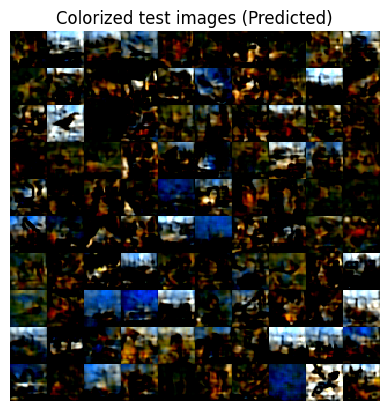

In [25]:
# predict the autoencoder output from test data
x_decoded = model.predict(x_test_gray)

# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

In [26]:
print("Evaluate on test data")
results = model.evaluate(x_test_gray, x_test, batch_size=128)
print("test loss, test mean_absolute_error:", results)



Evaluate on test data


2024-10-28 09:43:47.774545: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:47.775426: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:47.780552: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:47.781417: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:47.792100: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:47.793262: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:47.837384: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:47.838273: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:47.844651: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-10-28 09:43:47

79/79 [==============================] - 1s 8ms/step - loss: 0.3721 - acc: 0.5027
test loss, test mean_absolute_error: [0.3720511198043823, 0.5027424097061157]
